# General Information
**Riiid! Answer Correctness Prediction**
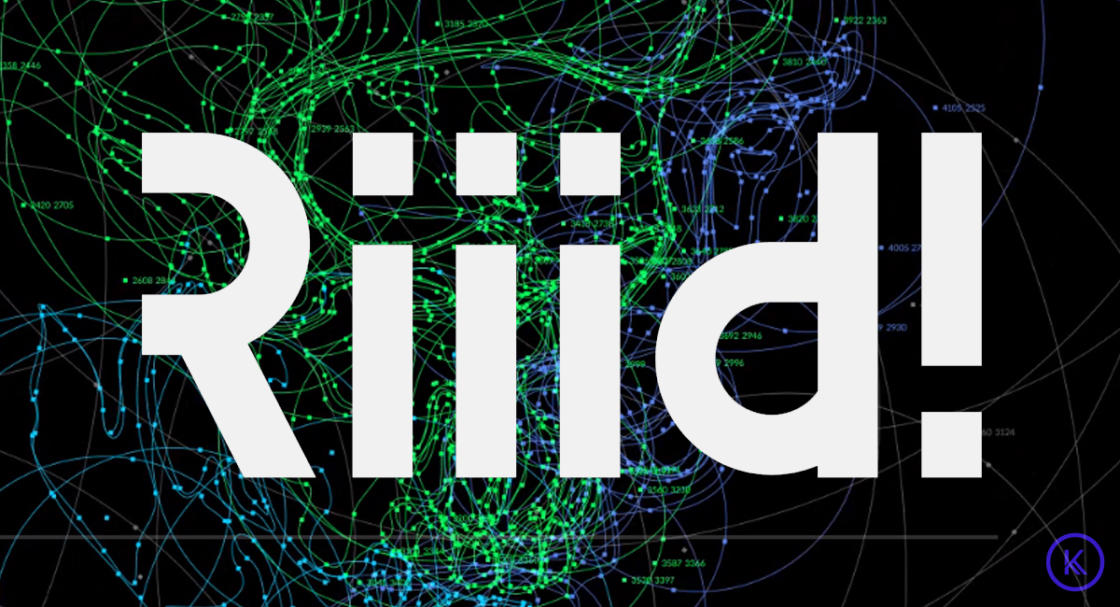
In this competition, your challenge is to **create algorithms for "Knowledge Tracing**," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions.
Challenge in this competition is to  predict whether students are able to answer their next questions correctly.

In this kernal we will **Explore the Data** and **understand the Data** , **Metric** used and hopefully find some Patterns in the data !!

The Evaluation Metric used is : **roc_auc_score** . 
roc_auc score will be computed between **predicted probability** and the **observed target**.



# Data Loading and Overview

In [ ]:
import os
os.listdir('../input/riiid-test-answer-prediction')

# Data Description
Challenge in this competition is to predict whether students are able to answer their next questions correctly.
This is a time-series code competition, you will receive test set data and make predictions with Kaggle's time-series API.

1. ***Train.csv***=> We have been provided the Features for the prediction of probability of answering next questions.

**row_id**: ID code for the row.

**timestamp**: time between this user interaction and the first event 

**user_id**: ID code for the user.

**content_id**: ID code for the user interaction

**content_type_id**: 0 if question else 1 for Lecture

**task_container_id**:  Id code for the batch of questions or lectures.

**user_answer**: the user's answer to the question,  Read -1 as null, for lectures.

**answered_correctly**: IF  the user responded correctly. Read -1 as null, for lectures.

**prior_question_elapsed_time**: (float32) How long it took a user to answer their previous question bundle, ignoring any lectures in between. It is the total time a user took to solve all  questions in the previous bundle.

**prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"


In [ ]:
# the Total number of rows in train.csv are 101M . So lets load a part of it 
train = pd.read_csv("../input/riiid-test-answer-prediction/train.csv", low_memory=False, 
    nrows=5000000,dtype={
        'row_id': 'int64', 
        'timestamp': 'int64', 
        'user_id': 'int32', 
        'content_id': 'int16', 
        'content_type_id': 'int8',
        'task_container_id': 'int16', 
        'user_answer': 'int8', 
        'answered_correctly': 'int8', 
        'prior_question_elapsed_time': 'float32', 
        'prior_question_had_explanation': 'boolean'
    })

In [ ]:
train.head(10)

In [ ]:
train.info()

In [ ]:
print(f'There are {train.shape[0]} rows in train data.')
print(f"Total number of Unique users in our train_df is {train['user_id'].nunique()}")

In [ ]:
sns.cubehelix_palette(as_cmap=True)



In [ ]:
# Lets check how many user saw an explanation and  correct response(s) after answering  previous question bundle.
ax = sns.countplot(x="prior_question_had_explanation", data=train, palette="Set3",hue="prior_question_had_explanation")


In [ ]:
ax = sns.countplot(x="answered_correctly", data=train,hue="answered_correctly")


In [ ]:
ax = sns.countplot(x="prior_question_had_explanation", data=train, palette="Set3",hue="answered_correctly")


In [ ]:
ax = sns.countplot(x="content_type_id", data=train, palette="Set3")


In [ ]:
ds = train['user_answer'].value_counts().reset_index()
ds.columns = ['answers', 'percent_of_answers']
ds['percent_of_answers'] /= len(train)
ds = ds.sort_values(['percent_of_answers'])
fig = px.bar(
    ds, 
    x='answers', 
    y='percent_of_answers', 
    orientation='v', 
    title='Percent of user answers', 
    height=500, 
    width=500
)
fig.show()

In [ ]:
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train.groupby(by='user_id').count()['row_id'], shade=True, gridsize=50, color='g', legend=False)
fig.figure.suptitle("User_id distribution", fontsize = 20)
plt.xlabel('User_id counts', fontsize=16)
plt.ylabel('Probability', fontsize=16);


In [ ]:
fig = px.histogram(
    train, 
    x="prior_question_elapsed_time",
    nbins=100,
    width=700,
    height=600,
    title='Time taken to solve all questions in the previous bundle'
)
fig.show()

**Let us Analyze and visualize individual user-id and its time-stamp and answers**

In [ ]:
ds = train[train['user_id'] == 115]
x = ds['timestamp']
y = ds['prior_question_elapsed_time']
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.distplot(y,ax=axes[0])
sns.distplot(x,ax=axes[1])

In [ ]:
ds.info()

The maximum occurance of Top User-Ids :

In [ ]:
df = train['user_id'].value_counts().reset_index()
df.columns = ['user_id', 'count']
df = df.sort_values(['count'])

In [ ]:
df['count'].value_counts()

In [ ]:
df = df.sort_values(['count'])
fig = px.bar(
    df.tail(50), 
    x='user_id', 
    y='count', 
    orientation='h', 
    title='Top 40 users', 
    height=800, 
    width=800
)

fig.show()

In [ ]:
print(f"Percentage of Lecture actvities = {(train['answered_correctly']==-1).mean()}%")


In [ ]:
train_questions_only_df = train[train['answered_correctly']!=-1]
train_questions_only_df['answered_correctly'].mean()


Average 66% of answers given are correct 

# Questions MetaData 

1. ***questions.csv*** => Metadata about the questions posted to the users

**question_id**: foreign key for the **content_id column**, when the content type is question (0).

**correct_answer**: Correct answer to the question assoiciated with question_id , can be used to check user's answer.

**tags**: one or more detailed tag codes for the question. They are sufficient for clustering the questions together.

In [ ]:
questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')

In [ ]:
questions.head()

In [ ]:
print(f"Total rows in questions metadata dataframe = {questions.shape[0]}")
print(f'Features in Questions dataframe = {questions.shape[1]}')

In [ ]:
sns.countplot(x='correct_answer',data=questions)

In [ ]:
sns.countplot(x='part',data=questions)

In [ ]:
quest_id = questions['question_id'].tolist()
# Need to check the intersection of questions-id and content_id to check whether the user answered correctly/not

# Lectures Data

1. ***lectures.csv*** => metadata for the lecutures watched as students progressed through their education

**lecture_id**: foreign key for the train/test content_id column, when the content type is lecture (1)

**tag**: Used for clustering together lectures

**type_of**: brief description of the core purpose of the lecture

In [ ]:
lectures = pd.read_csv("../input/riiid-test-answer-prediction/lectures.csv")

In [ ]:
lectures.head()

In [ ]:
sns.countplot(x='type_of',data=lectures)

In [ ]:
ds = lectures['tag'].value_counts().reset_index()
ds.columns = ['tag', 'count']
ds['tag'] = ds['tag'].astype(str) + '-'
ds = ds.sort_values(['count'])
fig = px.bar(
    ds.tail(40), 
    x='count', 
    y='tag', 
    orientation='h', 
    title='Top 40 lectures by number of tags', 
    height=800, 
    width=700
)
fig.show()

In [ ]:
sns.countplot(x='part',data=lectures,palette='Set3')

# Example_Test data

prior_group_responses (string) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

prior_group_answers_correct (string) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.

In [ ]:
ex_sub = pd.read_csv("../input/riiid-test-answer-prediction/example_test.csv")

In [ ]:
ex_sub

In [ ]:
# sample submission 
sample = pd.read_csv("../input/riiid-test-answer-prediction/example_sample_submission.csv")

In [ ]:
sample

The Probablity of answering correctly needs to be predicted .

Baseline:

credits = https://www.kaggle.com/ilialar/simple-eda-and-baseline

In [ ]:
grouped_by_user_df = train_questions_only_df.groupby('user_id')
content_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count'] })

user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count'] })

In [ ]:
active_users_dict = user_answers_df[user_answers_df[('answered_correctly','count')] >= 20][('answered_correctly','mean')].to_dict()
popular_questions_dict = content_answers_df[content_answers_df[('answered_correctly','count')] >= 20][('answered_correctly','mean')].to_dict()

In [ ]:
def predict_sample(user_id, content_id):
    if content_id in popular_questions_dict:
        return popular_questions_dict[content_id]
    if user_id in active_users_dict:
        return active_users_dict[user_id]
    return 0.658


In [ ]:
import riiideducation

env = riiideducation.make_env()

In [ ]:
iter_test = env.iter_test()


In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    test_df['answered_correctly'] = test_df.apply(lambda x: predict_sample(x['user_id'], x['content_id']), 1)
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])